# AutoKoopman Online System Identification

Example of planned online sys id.

In [1]:
import sys
sys.path.append("..")

import autokoopman.estimator.online_koopman as okoop
import autokoopman.core.observables as obs

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(20)

In [2]:
# initialize on short bursts
import autokoopman.benchmark.fhn as fhn
fhn = fhn.FitzHughNagumo()
training_data = fhn.solve_ivps(
    initial_states=np.random.uniform(low=-2.0, high=2.0, size=(3, 2)),
    tspan=[0.0, 0.3],
    sampling_period=0.1
)

In [3]:
# create an online estimator with order 3 polynomial observables
online = okoop.OnlineKoopmanEstimator(obs.PolynomialObservable(2, 3))
online.initialize(training_data)

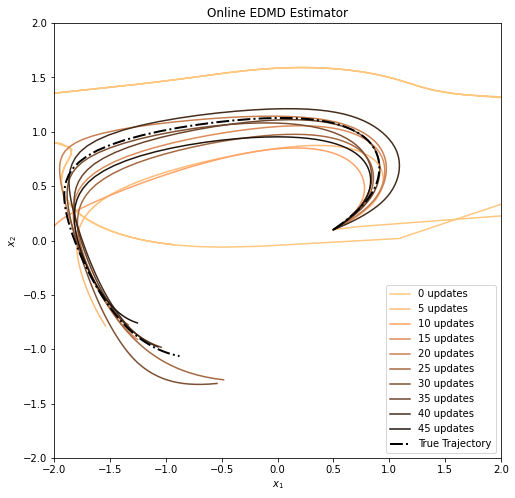

In [4]:
# simulate using the learned model
plt.figure(figsize=(8,8))
# get colors
num_colors = 50
cm = plt.get_cmap('copper')
colors_feature = [cm(1-i//3*3.0/num_colors) for i in range(num_colors)]

# test trajectory
def test_model(model):
    iv = [0.5, 0.1]
    return model.solve_ivp(
            initial_state=iv,
            tspan=(0.0, 10.0),
            sampling_period=0.1
        )

# plot as you update the streaming data
trajectory = test_model(online.model)
for idx in range(num_colors):
    if idx % 5 == 0:
        plt.plot(*trajectory.states.T, c=colors_feature[idx], label=f"{idx} updates")
    # new data
    streaming_data = fhn.solve_ivps(
        initial_states=np.random.uniform(low=-2.0, high=2.0, size=(1, 2)),
        tspan=[0.0, 1.0],
        sampling_period=0.1
    )
    # update the online estimator
    online.update(streaming_data)
    trajectory = test_model(online.model)

# simulate the ground truth for comparison
true_trajectory = test_model(fhn)

# plot the results
plt.plot(*true_trajectory.states.T, '-.k', linewidth=2.0, label="True Trajectory")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.title("Online EDMD Estimator")
plt.show()